In [1]:
import jax
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt  
from jax import grad, vmap


import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion

def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

# Use finite difference hessian for stepping.

In [2]:
import math
outer = lambda x, y: jnp.einsum('i,j->ij', x.conj(), y)
inner = lambda x, y: jnp.einsum('i,i->', x.conj(), y)
diff = lambda x: (x - jnp.roll(x, len(x)//10))/float(len(x)//10)*float(len(x))

Lhalf = 3
L = 2*Lhalf + 1
t = jnp.linspace(0, 2*jnp.pi, L+1)[:-1]
f = lambda t: t == 0. #> jnp.pi
#f = lambda t: t> jnp.pi
stdev = 0.01
N = 10000
x = f(t)
y, noise, shift = get_samples(random.PRNGKey(4), x, stdev, N)

xfft = fft(x)
xfft_abs = jnp.abs(xfft)
xfft0 = xfft[0]
yfft = fft(y, axis=1)    
ymean, yauto_fft, _ = invariants_from_data(y, stdev)
    
    
def to_xfft(angles, xfft_abs, xfft0):
    angles = jnp.concatenate([angles, -angles[::-1]])
    xfft = jnp.concatenate([jnp.array([xfft0]), jnp.exp(1j * angles) * xfft_abs[1:]])
    return xfft 

def shift_fft(shift, xfft):
    angles = jnp.angle(xfft[1:Lhalf+1])
    xfft = to_xfft(angles+shift, jnp.abs(xfft), xfft[0])
    return xfft
    
def loss(xfft):
    return loss_fft(xfft, yfft)

def loss_angle(angle, xfft_abs, xfft0):
    xfft = to_xfft(angle, xfft_abs, xfft0)
    return loss(xfft)

def e(i):
    e = jnp.zeros(Lhalf)
    e = e.at[i].set(1.)
    return e

def en(i, n):
    e = jnp.zeros(n)
    e = e.at[i].set(1.)
    return e

        
M = 50
angles = jnp.angle(xfft[1:Lhalf+1])
angles = angles + jnp.pi * jnp.array([1., 0., 0.])
i, j = 0, 1

loss_wrap = lambda t1, t2, i1, i2: loss_angle(angles + t1 * en(i1, len(angles)) + t2 * en(i2, len(angles)), xfft_abs, xfft0)
t1 = jnp.linspace(-jnp.pi, jnp.pi, M)
t2 = jnp.linspace(-jnp.pi, jnp.pi, M)
T1, T2 = jnp.meshgrid(t1, t2)

def loss_wrap_vmap(t1, t2, i1, i2):
    U = jnp.zeros((M, M))
    for i in range(M):
        U = U.at[i, :].set(vmap(lambda t1, t2: loss_wrap(t1, t2, i1, i2))(t1[i,:], t2[i,:]))
        print(i, end="\r")
    return U  


U = loss_wrap_vmap(T1, T2, 0, 1)
U2 = loss_wrap_vmap(T1, T2, 0, 2)
U3 = loss_wrap_vmap(T1, T2, 1, 2)

I0000 00:00:1719350934.823537   12820 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


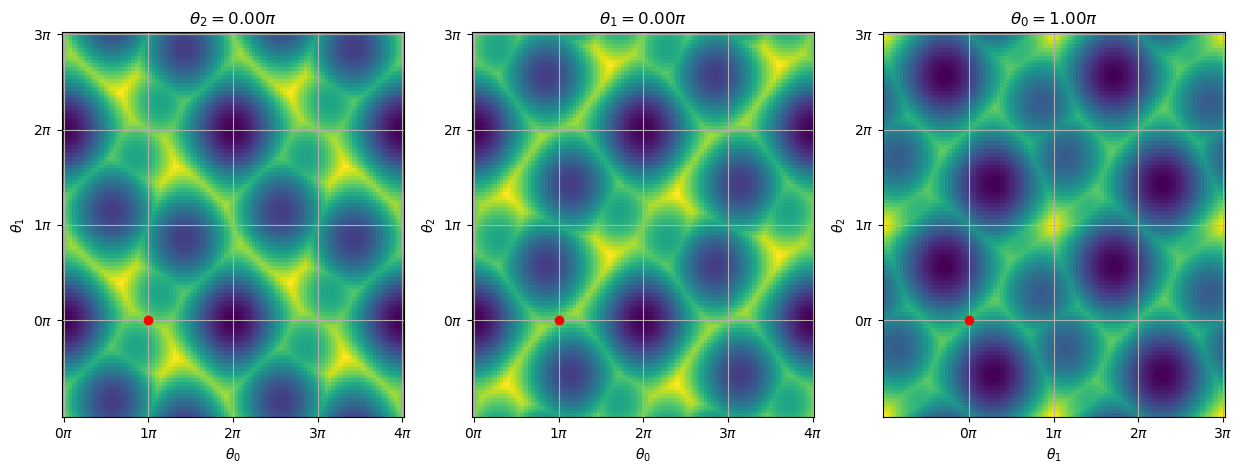

In [3]:
def stack_periodic(U):
    U = jnp.concatenate([U, U], axis=0)
    U = jnp.concatenate([U, U], axis=1)
    return U

def stack_shift(T1, T2, i1, i2):
    T1 = jnp.concatenate([T1, T1+2*jnp.pi], axis=1)
    T1 = jnp.concatenate([T1, T1], axis=0)
    
    T2 = jnp.concatenate([T2, T2+2*jnp.pi], axis=0)
    T2 = jnp.concatenate([T2, T2], axis=1)
    return T1 + angles[i1], T2 + angles[i2]

xyz = (angles[0], angles[1], angles[2])

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title(f"$\\theta_2={angles[2]/jnp.pi:.2f}\\pi$")
plt.pcolormesh(*stack_shift(T1,T2, 0, 1), stack_periodic(U)) 
plt.xticks([i*jnp.pi for i in range(5)], [f"${i}\pi$" for i in range(5)]) 
plt.yticks([i*jnp.pi for i in range(5)], [f"${i}\pi$" for i in range(5)]) 
plt.grid()
plt.xlabel("$\\theta_0$")
plt.ylabel("$\\theta_1$")
plt.scatter(xyz[0], xyz[1], c="red", zorder=10)

plt.subplot(132)
plt.title(f"$\\theta_1={angles[1]/jnp.pi:.2f}\\pi$")
plt.pcolormesh(*stack_shift(T1,T2, 0, 2), stack_periodic(U2)) 
plt.xlabel("$\\theta_0$")
plt.ylabel("$\\theta_2$")
plt.xticks([i*jnp.pi for i in range(5)], [f"${i}\pi$" for i in range(5)]) 
plt.yticks([i*jnp.pi for i in range(5)], [f"${i}\pi$" for i in range(5)]) 
plt.scatter(xyz[0], xyz[2], c="red", zorder=10)
plt.grid()

plt.subplot(133)
plt.title(f"$\\theta_0={angles[0]/jnp.pi:.2f}\\pi$")
plt.pcolormesh(*stack_shift(T1,T2, 1, 2), stack_periodic(U3)) 
plt.xlabel("$\\theta_1$")
plt.ylabel("$\\theta_2$")
plt.xticks([i*jnp.pi for i in range(5)], [f"${i}\pi$" for i in range(5)]) 
plt.yticks([i*jnp.pi for i in range(5)], [f"${i}\pi$" for i in range(5)]) 
plt.scatter(xyz[1], xyz[2], c="red", zorder=10)
plt.grid()